In [15]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline  
import os
import PIL
from PIL import Image
import tensorflow as tf
import glob

np.random.seed(123)  # for reproducibility
captcha_num_chars = 6
num_chars = 36

# Abrir dataset

JW4CZF


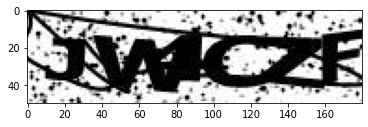

In [16]:
# Filelist dos dados
test_filelist = glob.glob('dados/teste/*.jpg')
valid_filelist = glob.glob('dados/validacao/*.jpg')
train_filelist = glob.glob('dados/treinamento/*.jpg')
labels_filelist = glob.glob('dados/labels10k/*.txt')

# Importar imagens
test  = np.array([np.array(Image.open(file).getchannel('R')) for file in test_filelist])
valid = np.array([np.array(Image.open(file).getchannel('R')) for file in valid_filelist])
train = np.array([np.array(Image.open(file).getchannel('R')) for file in train_filelist])
height, width = test.shape[1], test.shape[2]

# Importar labels
all_labels = [open(file, "r").read(captcha_num_chars) for file in labels_filelist]
test_lbs  = all_labels[9000:9999]
valid_lbs = all_labels[8000:8999]
train_lbs = all_labels[0:7999]

print(test_lbs[0])
plt.imshow(test[0], cmap='gray')

## Cortar as imagens

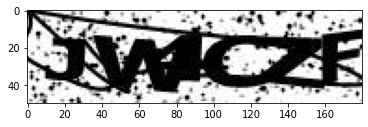

In [17]:
# Cortar cada imagem em 6 imagens separadas, 1 com cada caractere do captcha
captcha = test[0]

plt.imshow(captcha, cmap='gray')


## Preprocessamento dos dados de entrada para o Keras

In [18]:
# Reshape dos arrays
test = test.reshape(test.shape[0], height, width, 1)
valid = valid.reshape(valid.shape[0], height, width, 1)
train = train.reshape(train.shape[0], height, width, 1)

#print(test.shape)

In [19]:
# Normalização dos valores dos pixels para [0,1]
test = test.astype('float32') 
test /= 255
valid = valid.astype('float32') 
valid /= 255
train = train.astype('float32')
train /= 255

#print(test[0][0])

## Preprocessamento dos lables das classes para o Keras

In [20]:
'''
test = np_utils.to_categorical(test_lbs, num_chars)
valid = np_utils.to_categorical(valid_lbs, num_chars)
train = np_utils.to_categorical(train_lbs, num_chars)

print(test.shape)
print("class ID: ", test_lbs[0])
print("Network output: ", test[0][:])
'''

'\ntest = np_utils.to_categorical(test_lbs, num_chars)\nvalid = np_utils.to_categorical(valid_lbs, num_chars)\ntrain = np_utils.to_categorical(train_lbs, num_chars)\n\nprint(test.shape)\nprint("class ID: ", test_lbs[0])\nprint("Network output: ", test[0][:])\n'

# Definir arquitetura do modelo